<a href="https://colab.research.google.com/github/antoinebachand/Deep-Learnig-/blob/main/Binary_1target.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Neural Network for Prediction of Hydrogen Thermodynamics**
# **Binary with 1 Target**
### Author: Antoine Bachand (antoinebachand@outlook.com)

The training data set is obtained through a model adapted from Kushnir et al. (2012) for hydrogen storage. DOI: 10.1016/j.ijheatmasstransfer.2012.05.055 


In [131]:
import pandas as pd
import numpy
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn.functional as functional
import torch.nn as nn
import torchvision
from torchvision import transforms, datasets


In [132]:
#load the data
df = pd.read_csv('data_10000.csv')
df.columns = ['Injection Temperature (K)', 'Intitial Temperature (K)', 'Total Mass (kg)', 'Injection Time (s)', 'Max Pressure (MPa)','Max Temperature (Celsius)']

The inputs to the neural network are:
- Initial rock temperature (K)
- Injection temperature (K)
- Total injection mass (kg)
- Injection time (s) 

and the outputs are as follows:
- Maximum pressure ( MPa )
- Maximum temperature ( °C )  

In [133]:
df.head()

,Injection Temperature (K),Intitial Temperature (K),Total Mass (kg),Injection Time (s),Max Pressure (MPa),Max Temperature (Celsius)
0,282.469062,300.763007,1869.140142,13607.354450,110.988812,67.340630
1,399.261432,306.867055,611.049819,14247.207020,24.467629,59.982319
2,332.949980,308.329176,1435.526958,5114.476186,79.346296,98.232711
3,398.578465,303.391355,1600.185040,15412.538030,92.198101,96.047796
4,329.299607,304.099858,871.039883,8019.916604,37.879257,66.882724


In [134]:
df.describe()

,Injection Temperature (K),Intitial Temperature (K),Total Mass (kg),Injection Time (s),Max Pressure (MPa),Max Temperature (Celsius)
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,373.359956,292.831066,1251.091858,13534.993797,70.186064,87.375692
std,57.798521,11.607488,431.115254,5781.543880,61.757836,166.266974
min,273.028357,273.005582,500.074091,3600.220147,16.635890,9.773542
25%,323.171228,282.742639,877.214602,8496.583859,37.319443,52.352185
50%,373.583463,292.672869,1255.380370,13463.256415,61.838304,70.354742
75%,423.437581,302.876639,1626.478623,18582.071768,91.863710,93.249890
max,472.990125,312.998830,1999.955495,23599.455440,2369.358069,8172.750350


# Binary modification

Here we simplify the dataset to develop a first version of the neural network. We use only 1 target (the pressure) instead of two and we transform this last output in a binary form (0 when the pressure is lower than 50 MPa and 1 when it is higher than 50 MPa)

In [135]:
Binary_Pressure = []
for i in df['Max Pressure (MPa)']:
  if i < 50:
    Binary_Pressure.append(0)
  else:
    Binary_Pressure.append(1) 

df['Binary_Pressure'] = Binary_Pressure

df_drop = df.drop(['Max Pressure (MPa)','Max Temperature (Celsius)',],axis=1)

df_drop.head()

,Injection Temperature (K),Intitial Temperature (K),Total Mass (kg),Injection Time (s),Binary_Pressure
0,282.469062,300.763007,1869.140142,13607.354450,1
1,399.261432,306.867055,611.049819,14247.207020,0
2,332.949980,308.329176,1435.526958,5114.476186,1
3,398.578465,303.391355,1600.185040,15412.538030,1
4,329.299607,304.099858,871.039883,8019.916604,0


Since our different features are on different ranges, a normalization is applied.

In [136]:
# Normalization
norm = MinMaxScaler().fit(df_drop) 
nd_norm = norm.transform(df_drop)
df_norm = pd.DataFrame(nd_norm)

df_norm.columns = ['Injection Temperature (K)', 'Intitial Temperature (K)', 'Total Mass (kg)', 'Injection Time (s)', 'Max Pressure']


In [137]:
df_norm.describe()

,Injection Temperature (K),Intitial Temperature (K),Total Mass (kg),Injection Time (s),Max Pressure
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.501754,0.495721,0.500718,0.496758,0.605800
std,0.289048,0.290236,0.287433,0.289088,0.488703
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.250762,0.243468,0.251447,0.244828,0.000000
50%,0.502872,0.491765,0.503577,0.493171,1.000000
75%,0.752190,0.746903,0.750996,0.749121,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000


#Preparing data for training/testing

Here we split the data between training (80%) and testing (20%) in order to test the neural network with unseen data

In [138]:
# The columns are split between independent (Input) and dependent (Output)
columns = df_norm.columns.values.tolist()
# The independent ones correspond to the last two columns of the data set. 
independent = columns[:-1]
dependent = columns[-1]         

# The test data size is set at 20%. 
X_train, X_test, y_train, y_test = train_test_split(df_norm[independent],df_norm[dependent], test_size=0.2)


Now we will create the tensors. They correspond to the structure used to store information/data in machine learning. 

Also, since the stochastic gradient descent computes the gradient on a subset of the training data, as opposed to the entire training dataset, we need to specify a batch size. Therefore, to avoid generalization, we will use a small batch size of 50. 

In [139]:
BATCH_SIZE = 50
# Tensor for the training data and the value type is float 
X = torch.tensor(X_train.values, dtype=torch.float)
y = torch.tensor(y_train.values, dtype=torch.int64)

train_ds = torch.utils.data.TensorDataset(X,y)

# Tensor for the testing data and the value type is float
X = torch.tensor(X_test.values, dtype=torch.float)
y = torch.tensor(y_test.values, dtype=torch.int64)

test_ds = torch.utils.data.TensorDataset(X,y)

# We shuffle the training dataset and split in batch size
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE,shuffle=True)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)


# Network architecture

The architecture of the neural network consists of 3 hidden layers with 50 neurons. The activation function used is ReLU except for the output layer we use the sigmoid function since the output is binary.  

In [140]:
class MyANN(nn.Module):
  
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(4, 50)         # << We have 4 input features >>
    self.av1 = nn.ReLU()   
    self.fc2 = nn.Linear(50, 50)    
    self.av2 = nn.ReLU()
    self.fc3 = nn.Linear(50, 50) 
    self.av3 = nn.ReLU() 
    self.fc4 = nn.Linear(50, 50) 
    self.av4 = nn.ReLU()
    self.fc5 = nn.Linear(50, 2)         # << We have a binary output so only 2 out features >>
    self.av5 = nn.Sigmoid()             # << Since we have a binary output we use the Sigmoid >>
    return


  def forward(self, x):
    x = self.fc1(x)
    x = self.av1(x)
    x = self.fc2(x)
    x = self.av2(x)
    x = self.fc3(x)
    x = self.av3(x)
    x = self.fc4(x)
    x = self.av4(x)
    x = self.fc5(x)
    x = self.av5(x)
    return nn.functional.log_softmax(x, dim=1)

net = MyANN()
print(net)

MyANN(
  (fc1): Linear(in_features=4, out_features=50, bias=True)
  (av1): ReLU()
  (fc2): Linear(in_features=50, out_features=50, bias=True)
  (av2): ReLU()
  (fc3): Linear(in_features=50, out_features=50, bias=True)
  (av3): ReLU()
  (fc4): Linear(in_features=50, out_features=50, bias=True)
  (av4): ReLU()
  (fc5): Linear(in_features=50, out_features=2, bias=True)
  (av5): Sigmoid()
)


# Training

At the training level the optimizer used is Adam. The learning rate was initially set to 0.001 and the number of epochs to 200.

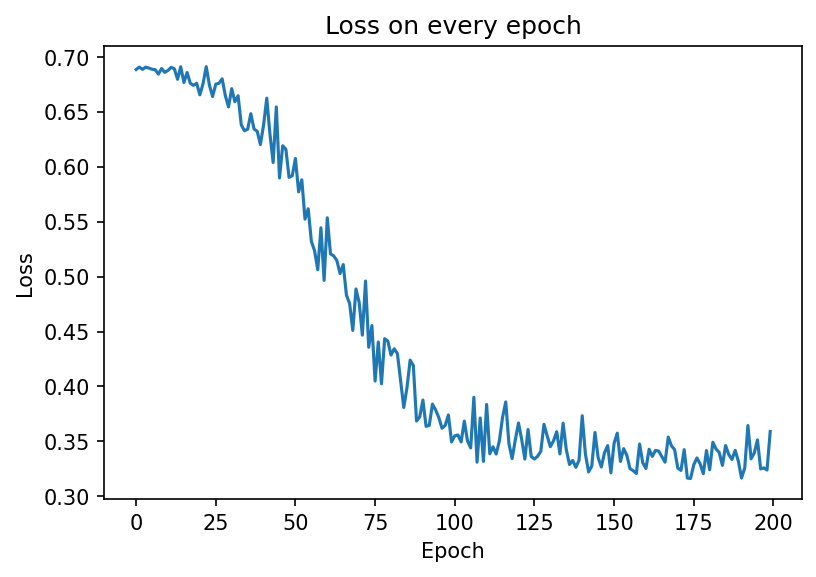

In [141]:
# First we set the optimizer 
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)   # << We choose the Adam optimizer and a learning rate of 0.001 >>

# Now we create a loop of n number of epochs.
losses = []
for epocs in range(200):                                   
  for data in train_dl:                                    # << Here, we also apply a loop inside the training data set >>
    X, y = data                                            # << We specify the inputs and outputs in batch >>
    # We clear the gradient information with .zero_grad()                                           
    optimizer.zero_grad() 
    # Forward pass                                        
    output = net(X.view(-1, 4))                            # << Our 4 columns of inputs are passed through the network  >>

    # Now we calculate the loss with our output compare to the target (y)
    loss = nn.functional.nll_loss(output, y)
    # We apply the backpropagation                         
    loss.backward()                                        # << Here we reset the weights >>
  #Finally, we tell the optimizer that the Batch iteration is finished.   
  optimizer.step() 
  # We print the loss for each epoch 
  #print(loss.data)
  losses.append(loss.data.numpy())   

# Here we plot the losses against the number of epochs.
# Ideally, the losses constantly decrease and stabillize at the end of the training.  
plt.plot(losses)                
plt.title('Loss on every epoch')     # << HOWEVER, it is NECESSARY to make certain later on that there is no overfitting. >>
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.gcf().set_dpi(150)

 

# Testing and Regulation (overfitting)
Here, we want to check the accuracy on the test data and also assess whether there is an overfitting on the training data (looking at the difference between the test accuracy and the training accuracy).

In [143]:
total = 0
correct = 0

# Here we disable the calculation of the gradient since we won't call backward()
with torch.no_grad():      
  for data in test_dl:
    X, y = data                          #  << We specify the inputs and outputs in batch >>
    # Forward pass
    output = net(X.view(-1, 4))          
    
    for idx, val in enumerate(output):  #  << idx is the batch index and and val is the output weights after the forward pass??? >>
      
      # Here we use torch.argmax to vote for the output feature. It Returns the indices of the maximum value of all elements in the tensor                                       
      if torch.argmax(val) == y[idx]:   #  << We compare the prediction to the same index of the target y >>
        correct += 1
      total += 1
      # print(torch.argmax(val), val)   #  << To understand torch.argmax(val) >>
      
  
  print('Accuracy:', round(correct/total, 4)*100, '%')

Accuracy: 98.75 %
